# **Passo 1: Leitura e Preparação dos Dados**

In [ ]:
import pandas as pd
import numpy as np

# Se estiver no Google Colab, descomente:
# from google.colab import files

# 1. Fazer upload dos arquivos CSV
# Descomente se estiver no Google Colab para fazer o upload manual:
# uploaded = files.upload()

# 2. Ler cada arquivo separadamente
df_clientes = pd.read_csv("clientes.csv")    # Ex.: "clientes.csv"
df_transacoes = pd.read_csv("transacoes.csv")# Ex.: "transacoes.csv"
df_campanhas = pd.read_csv("campanhas.csv")  # Ex.: "campanhas.csv"

# Verificando as primeiras linhas de cada dataset
print("Clientes:")
display(df_clientes.head())

print("Transações:")
display(df_transacoes.head())

print("Campanhas:")
display(df_campanhas.head())

# Verificando informações básicas
print("\nInfo df_clientes:")
print(df_clientes.info())

print("\nInfo df_transacoes:")
print(df_transacoes.info())

print("\nInfo df_campanhas:")
print(df_campanhas.info())


Clientes:


,cliente_id,idade,renda_mensal,cidade,tipo_cliente,ultima_compra,frequencia_compras,total_gasto
0,1,56,2590,Curitiba,ocasional,63,12,6779
1,2,69,5305,Manaus,frequente,104,4,7310
2,3,46,3865,Porto Alegre,frequente,339,8,4170
3,4,32,2866,Porto Alegre,ocasional,359,7,4619
4,5,60,4030,Porto Alegre,premium,156,7,3869


Transações:


,transacao_id,cliente_id,data_compra,valor_compra,meio_pagamento,campanha
0,1,398,2022-01-01,161,cartão,sem_campanha
1,2,583,2022-01-02,116,boleto,sem_campanha
2,3,726,2022-01-03,173,cartão,dia_pais
3,4,435,2022-01-04,148,cartão,volta_as_aulas
4,5,577,2022-01-05,21,cartão,dia_pais


Campanhas:


,campanha_id,nome_campanha,custo_campanha,alcance,conversao
0,1,black_friday,16361,3245,497
1,2,natal,9721,1242,442
2,3,dia_maes,12684,4650,264
3,4,dia_pais,12198,3033,64
4,5,volta_as_aulas,13136,2337,196



Info df_clientes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   cliente_id          1000 non-null   int64 
 1   idade               1000 non-null   int64 
 2   renda_mensal        1000 non-null   int64 
 3   cidade              1000 non-null   object
 4   tipo_cliente        1000 non-null   object
 5   ultima_compra       1000 non-null   int64 
 6   frequencia_compras  1000 non-null   int64 
 7   total_gasto         1000 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 62.6+ KB
None

Info df_transacoes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transacao_id    5000 non-null   int64 
 1   cliente_id      5000 non-null   int64 
 2   data_compra     5000 non-null   

# **Passo 2: Cluster Analysis (Segmentação de Clientes)**

## **2.1 Pré-processamento e K-means**

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Selecionando variáveis para clustering
X_cluster = df_clientes[["frequencia_compras", "total_gasto", "ultima_compra"]]

# Normalizando os dados
scaler = StandardScaler()
X_cluster_scaled = scaler.fit_transform(X_cluster)

# Aplicando K-means (ex.: 4 clusters)
kmeans = KMeans(n_clusters=4, random_state=42)
df_clientes["cluster"] = kmeans.fit_predict(X_cluster_scaled)

# Exibindo a contagem de clientes em cada cluster
print("Contagem de clientes por cluster:")
print(df_clientes["cluster"].value_counts())


Contagem de clientes por cluster:
cluster
0    288
2    248
3    247
1    217
Name: count, dtype: int64


## **2.2 Visualização Interativa (Plotly)**

In [ ]:
import plotly.express as px

fig_cluster = px.scatter(
    df_clientes,
    x="frequencia_compras",
    y="total_gasto",
    color="cluster",
    hover_data=["cliente_id", "ultima_compra"],
    title="Segmentação de Clientes (K-Means)",
    color_continuous_scale=px.colors.sequential.Viridis
)
fig_cluster.update_layout(width=800, height=500)
fig_cluster.show()


# **Passo 3: Conjoint Analysis (Preferências dos Clientes)**

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import plotly.express as px

# --- Dados simulados para Conjoint Analysis ---
np.random.seed(42)
n_respostas = len(df_clientes)

# Simulação de atributos de campanha e a escolha (0 = não escolheu, 1 = escolheu)
conjoint_data = {
    "desconto": np.random.choice([0, 10, 20], size=n_respostas),
    "frete_gratis": np.random.choice([0, 1], size=n_respostas),
    "brinde": np.random.choice([0, 1], size=n_respostas),
    "escolha": np.random.choice([0, 1], size=n_respostas, p=[0.4, 0.6])
}

df_conjoint = pd.DataFrame(conjoint_data)

# Adicionando o tipo de cliente para análise (assumindo correspondência direta de índices)
df_conjoint["tipo_cliente"] = df_clientes["tipo_cliente"].values

# --- Modelagem via Regressão Logística (Logit) ---
X = df_conjoint[["desconto", "frete_gratis", "brinde"]]
X = sm.add_constant(X)  # Adicionando o intercepto
y = df_conjoint["escolha"]

model = sm.Logit(y, X)
result = model.fit()
print(result.summary())

# Extraindo os coeficientes (importância relativa dos atributos)
coeficientes = result.params.drop("const")

# --- Gráfico de Barras: Importância dos Atributos ---
fig_conjoint = px.bar(
    x=coeficientes.index,
    y=coeficientes.values,
    title="Importância dos Atributos (Conjoint Analysis)",
    labels={"x": "Atributos", "y": "Coeficiente"}
)
fig_conjoint.update_layout(width=700, height=400)
fig_conjoint.show()

# --- Heatmap: Preferências por Tipo de Cliente ---
# Calculando, para os casos em que o perfil foi escolhido (escolha==1),
# a média dos atributos presentes. Isso reflete, de forma simplificada,
# quais atributos os clientes de cada tipo tendem a preferir.
df_preferencias = df_conjoint[df_conjoint["escolha"] == 1].groupby("tipo_cliente")[["desconto", "frete_gratis", "brinde"]].mean()

fig_heatmap = px.imshow(
    df_preferencias,
    text_auto=True,
    labels=dict(x="Atributos", y="Tipo de Cliente", color="Média"),
    x=["Desconto", "Frete Grátis", "Brinde"],
    y=df_preferencias.index,
    title="Heatmap de Preferências por Tipo de Cliente (Média dos Atributos em Escolhas)"
)
fig_heatmap.update_layout(width=700, height=400)
fig_heatmap.show()


Optimization terminated successfully.
         Current function value: 0.666555
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:                escolha   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      996
Method:                           MLE   Df Model:                            3
Date:                Wed, 09 Apr 2025   Pseudo R-squ.:                0.004599
Time:                        21:15:13   Log-Likelihood:                -666.55
converged:                       True   LL-Null:                       -669.63
Covariance Type:            nonrobust   LLR p-value:                    0.1041
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2944      0.134      2.199      0.028       0.032       0.557
desconto         0.0194

# **Passo 4: Regressão Linear (Previsão de Vendas / Total Gasto)**

In [ ]:
from sklearn.linear_model import LinearRegression

# Selecionando variáveis
X_reg = df_clientes[["idade", "renda_mensal", "frequencia_compras"]]
y_reg = df_clientes["total_gasto"]

# Modelo de regressão linear
reg_model = LinearRegression()
reg_model.fit(X_reg, y_reg)

# Coeficientes
print("Intercepto (beta0):", reg_model.intercept_)
print("Coeficientes (beta1, beta2, ...):", reg_model.coef_)

# Previsão
df_clientes["total_gasto_previsto"] = reg_model.predict(X_reg)

# Visualizando resultados (Plotly)
fig_reg = px.scatter(
    df_clientes,
    x="total_gasto",
    y="total_gasto_previsto",
    title="Previsão de Total Gasto vs. Real",
    labels={"total_gasto": "Total Gasto Real", "total_gasto_previsto": "Total Gasto Previsto"}
)
fig_reg.update_traces(marker=dict(color="blue", size=5))
fig_reg.update_layout(width=700, height=400)
fig_reg.show()


Intercepto (beta0): 4445.179418931658
Coeficientes (beta1, beta2, ...): [ 6.28690018  0.01676508 13.94993423]


# **Passo 5: Customer Lifetime Value (CLV)**

In [ ]:
df_clientes["clv"] = df_clientes["total_gasto"] * df_clientes["frequencia_compras"]

# Identificando clientes de alto valor (top 20%)
limiar_80 = df_clientes["clv"].quantile(0.8)
df_clientes["clv_alto_valor"] = df_clientes["clv"] > limiar_80

# Visualizando distribuição do CLV (Plotly)
fig_clv = px.histogram(
    df_clientes,
    x="clv",
    nbins=30,
    title="Distribuição do Customer Lifetime Value (CLV)",
)
fig_clv.update_layout(width=700, height=400)
fig_clv.show()

# Exibindo alguns clientes de alto valor
clientes_alto_valor = df_clientes[df_clientes["clv_alto_valor"]]
print("Clientes de Alto Valor (top 20%):")
display(clientes_alto_valor[["cliente_id", "clv", "frequencia_compras", "total_gasto"]].head())


Clientes de Alto Valor (top 20%):


,cliente_id,clv,frequencia_compras,total_gasto
0,1,81348,12,6779
8,9,67368,12,5614
11,12,68256,12,5688
20,21,82524,13,6348
23,24,91788,12,7649


# **Passo 6: Comparando CLV por Campanha (Exemplo de Integração)**

In [ ]:
# Supondo que a coluna 'campanha' em transacoes indica o nome da campanha
# e não o 'campanha_id'. Ajuste conforme necessário.

df_transacoes_merged = pd.merge(
    df_transacoes,
    df_clientes[["cliente_id", "clv"]],
    on="cliente_id",
    how="left"
)

# Agrupando por campanha e calculando CLV médio
df_campanha_clv = df_transacoes_merged.groupby("campanha")["clv"].mean().reset_index()

print("CLV médio por campanha:")
display(df_campanha_clv)

# Visualização interativa
fig_campanha_clv = px.bar(
    df_campanha_clv,
    x="campanha",
    y="clv",
    title="CLV Médio por Campanha",
    labels={"campanha": "Campanha", "clv": "CLV Médio"}
)
fig_campanha_clv.update_layout(width=700, height=400)
fig_campanha_clv.show()


CLV médio por campanha:


,campanha,clv
0,ano_novo,49284.139676
1,black_friday,50131.920160
2,dia_maes,49437.121756
3,dia_pais,48620.507605
4,natal,49544.111801
5,sem_campanha,48702.068695
6,volta_as_aulas,49037.610503


# **Passo 7: Visualizações Integradas (Exemplo de Dashboard Simplificado)**

In [ ]:
import plotly.subplots as sp
import plotly.graph_objs as go

# Criando figuras separadas
# (Vamos reaproveitar dados já calculados acima)

# 1) Cluster Analysis (2D scatter)
trace_cluster = go.Scatter(
    x=df_clientes["frequencia_compras"],
    y=df_clientes["total_gasto"],
    mode="markers",
    marker=dict(color=df_clientes["cluster"], colorscale="Viridis", showscale=True),
    name="Clusters"
)

# 2) Conjoint Analysis (barras dos coeficientes)
trace_conjoint = go.Bar(
    x=coeficientes.index,
    y=coeficientes.values,
    marker=dict(color="skyblue"),
    name="Importância dos Atributos"
)

# 3) Regressão Linear (scatter real vs previsto)
trace_reg = go.Scatter(
    x=df_clientes["total_gasto"],
    y=df_clientes["total_gasto_previsto"],
    mode="markers",
    marker=dict(color="blue"),
    name="Regressão Linear"
)

# 4) CLV (histograma)
trace_clv = go.Histogram(
    x=df_clientes["clv"],
    nbinsx=30,
    marker=dict(color="purple"),
    name="CLV"
)

# Criando subplots 2x2
fig_dashboard = sp.make_subplots(rows=2, cols=2,
                                 subplot_titles=[
                                     "Cluster Analysis",
                                     "Conjoint Analysis",
                                     "Regressão Linear",
                                     "Distribuição CLV"
                                 ])

# Adicionando cada gráfico em sua posição
fig_dashboard.add_trace(trace_cluster, row=1, col=1)
fig_dashboard.add_trace(trace_conjoint, row=1, col=2)
fig_dashboard.add_trace(trace_reg, row=2, col=1)
fig_dashboard.add_trace(trace_clv, row=2, col=2)

# Ajustando layout
fig_dashboard.update_layout(
    title="Painel de Visualizações Integradas",
    width=1000,
    height=800
)

fig_dashboard.show()


# **Passo 8: RFM (Recência, Frequência, Valor)**

In [ ]:
# RFM (Recência, Frequência, Valor)
df_clientes["recencia"] = df_clientes["ultima_compra"]
df_clientes["frequencia"] = df_clientes["frequencia_compras"]
df_clientes["valor"] = df_clientes["total_gasto"]

# Normalizando para análise
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

rfm_scaled = StandardScaler().fit_transform(df_clientes[["recencia", "frequencia", "valor"]])
rfm_kmeans = KMeans(n_clusters=4, random_state=42)
df_clientes["rfm_cluster"] = rfm_kmeans.fit_predict(rfm_scaled)

# Mostrando quantos clientes há por cluster
print("Distribuição de clientes por RFM cluster:")
print(df_clientes["rfm_cluster"].value_counts())

# Mostrando estatísticas por cluster
print("\nMédias de recência, frequência e valor por cluster:")
print(df_clientes.groupby("rfm_cluster")[["recencia", "frequencia", "valor"]].mean())

# Visualização com Plotly

fig_rfm = px.scatter_3d(
    df_clientes,
    x="recencia",
    y="frequencia",
    z="valor",
    color="rfm_cluster",
    hover_data=["cliente_id"],
    title="Segmentação de Clientes com RFM"
)
fig_rfm.show()


Distribuição de clientes por RFM cluster:
rfm_cluster
0    288
2    248
3    247
1    217
Name: count, dtype: int64

Médias de recência, frequência e valor por cluster:
               recencia  frequencia        valor
rfm_cluster                                     
0             80.409722    8.062500  4825.010417
1            142.645161   14.216590  5037.631336
2            261.120968    9.225806  6346.782258
3            263.412955    9.279352  3597.072874


## **Passo 9: Análise de churn simples (simulada)**

In [ ]:
# Análise de churn simples (simulada)
# Suponha que clientes com 'ultima_compra' > 180 dias são inativos
df_clientes["churn"] = df_clientes["ultima_compra"] > 180
churn_rate = df_clientes["churn"].mean()

# Mostrar a taxa de churn
print(f"\nTaxa de churn estimada: {churn_rate:.2%}")

# Mostrar quantos clientes são churn
total_churn = df_clientes["churn"].sum()
total_clientes = len(df_clientes)
print(f"Total de clientes churn: {total_churn} de {total_clientes}")

# Exibir alguns clientes churn
print("\nClientes considerados churn:")
print(df_clientes[df_clientes["churn"]].head())




Taxa de churn estimada: 52.00%
Total de clientes churn: 520 de 1000

Clientes considerados churn:
    cliente_id  idade  renda_mensal          cidade tipo_cliente  \
2            3     46          3865    Porto Alegre    frequente   
3            4     32          2866    Porto Alegre    ocasional   
5            6     25          3377          Manaus    ocasional   
8            9     36          4988  Belo Horizonte    frequente   
12          13     41          7284        Curitiba    ocasional   

    ultima_compra  frequencia_compras  total_gasto  cluster  \
2             339                   8         4170        3   
3             359                   7         4619        3   
5             273                   8         5573        2   
8             184                  12         5614        1   
12            293                   6         4717        3   

    total_gasto_previsto  ...  clv_alto_valor  recencia  frequencia  valor  \
2            4910.773316  ...      

## **Passo 10: Score de propensão à recompra (regressão logística simples)**

In [ ]:
# Score de propensão à recompra (regressão logística simples)
from sklearn.linear_model import LogisticRegression

# Define clientes que compraram nos últimos 30 dias como "positivos"
df_clientes["comprou_recentemente"] = df_clientes["ultima_compra"] < 30
X_recompra = df_clientes[["idade", "renda_mensal", "frequencia_compras"]]
y_recompra = df_clientes["comprou_recentemente"]

# Treina o modelo
modelo_recompra = LogisticRegression()
modelo_recompra.fit(X_recompra, y_recompra)

# Calcula a probabilidade de recompra
df_clientes["score_recompra"] = modelo_recompra.predict_proba(X_recompra)[:, 1]

# Exibe a distribuição dos scores
print("\nDistribuição dos scores de recompra:")
print(df_clientes["score_recompra"].describe())

# Mostra os 5 clientes com maior chance de recompra
print("\nTop 5 clientes com maior score de recompra:")
print(df_clientes[["cliente_id", "score_recompra"]].sort_values(by="score_recompra", ascending=False).head())

# Visualização

fig_recompra = px.histogram(
    df_clientes,
    x="score_recompra",
    nbins=30,
    title="Distribuição dos Scores de Propensão à Recompra",
    labels={"score_recompra": "Score de Recompra"}
)
fig_recompra.update_layout(width=700, height=400)
fig_recompra.show()




Distribuição dos scores de recompra:
count    1000.000000
mean        0.088000
std         0.016755
min         0.048501
25%         0.076113
50%         0.086248
75%         0.098302
max         0.146515
Name: score_recompra, dtype: float64

Top 5 clientes com maior score de recompra:
     cliente_id  score_recompra
683         684        0.146515
172         173        0.144072
339         340        0.143377
421         422        0.142888
504         505        0.136448


## **Passo 11: Árvore de decisão para prever total gasto**

In [ ]:
# Árvore de decisão para prever total gasto
from sklearn.tree import DecisionTreeRegressor


# Seleção das variáveis
X_reg = df_clientes[["idade", "renda_mensal", "frequencia_compras"]]
y_reg = df_clientes["total_gasto"]

# Modelo
arvore = DecisionTreeRegressor(max_depth=4, random_state=42)
arvore.fit(X_reg, y_reg)

# Previsões
df_clientes["gasto_prev_arvore"] = arvore.predict(X_reg)

# Exibe as 5 primeiras previsões
print("\nComparação entre valor real e previsto (árvore de decisão):")
print(df_clientes[["cliente_id", "total_gasto", "gasto_prev_arvore"]].head())

# Importância das variáveis no modelo
importancias = arvore.feature_importances_
for col, imp in zip(X_reg.columns, importancias):
    print(f"Importância de {col}: {imp:.4f}")

# Gráfico: Valor real vs previsto
fig_arvore = px.scatter(
    df_clientes,
    x="total_gasto",
    y="gasto_prev_arvore",
    title="Previsão de Total Gasto vs. Real (Árvore de Decisão)",
    labels={"total_gasto": "Total Gasto Real", "gasto_prev_arvore": "Previsão (Árvore)"},
)
fig_arvore.update_traces(marker=dict(color="green", size=5))
fig_arvore.update_layout(width=700, height=400)
fig_arvore.show()




Comparação entre valor real e previsto (árvore de decisão):
   cliente_id  total_gasto  gasto_prev_arvore
0           1         6779        4929.005848
1           2         7310        4763.980989
2           3         4170        4929.005848
3           4         4619        4929.005848
4           5         3869        4929.005848
Importância de idade: 0.2552
Importância de renda_mensal: 0.6241
Importância de frequencia_compras: 0.1207


## **Passo 12: Cluster hierárquico (dendrograma aprimorado)**

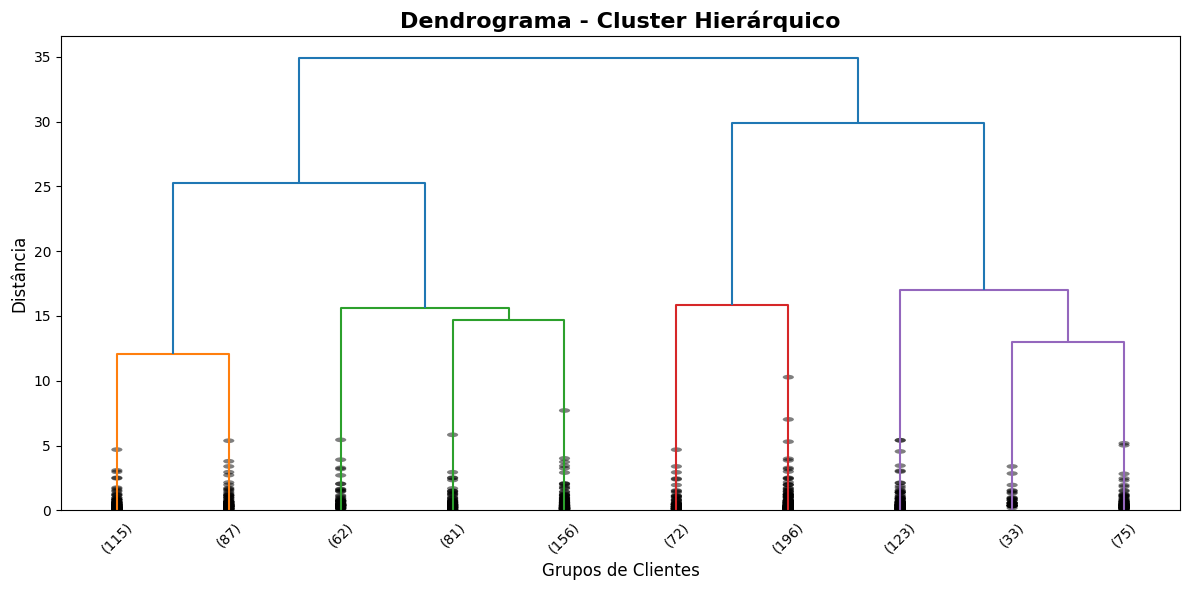

In [ ]:
# Cluster hierárquico (dendrograma aprimorado)
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt

# Cria o linkage
linked = linkage(X_cluster_scaled, method='ward')

# Estilo de visualização
plt.figure(figsize=(12, 6))
dendrogram(
    linked,
    truncate_mode='lastp',
    p=10,
    leaf_rotation=45.,
    leaf_font_size=12,
    show_contracted=True,
    color_threshold=0.7 * max(linked[:, 2])  # destaca os clusters em cores
)

# Melhorias visuais
plt.title("Dendrograma - Cluster Hierárquico", fontsize=16, weight='bold')
plt.xlabel("Grupos de Clientes", fontsize=12)
plt.ylabel("Distância", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()



## **Passo 13: Calcula o CLV médio por cluster**

In [ ]:
# Calcula o CLV médio por cluster
clv_por_cluster = df_clientes.groupby("cluster")["clv"].mean().reset_index()

# Visualização com Plotly
fig_clv_cluster = px.bar(
    clv_por_cluster,
    x="cluster",
    y="clv",
    text="clv",
    title="CLV Médio por Cluster de Clientes",
    labels={"cluster": "Cluster", "clv": "CLV Médio (R$)"},
    color="clv",  # coloração baseada no valor
    color_continuous_scale="Viridis"
)

# Ajustes visuais
fig_clv_cluster.update_traces(texttemplate="R$ %{text:.2f}", textposition="outside")
fig_clv_cluster.update_layout(
    yaxis_title="CLV Médio (R$)",
    xaxis_title="Cluster",
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    width=700,
    height=400
)

fig_clv_cluster.show()



## **Passo 14: Calcula a correlação entre as variáveis**

In [ ]:
# Calcula a correlação entre as variáveis
corr = df_clientes[["idade", "renda_mensal", "frequencia_compras", "total_gasto", "clv"]].corr()

# Cria o heatmap interativo
fig_corr = px.imshow(
    corr,
    text_auto=".2f",  # mostra os valores com 2 casas decimais
    color_continuous_scale="RdBu_r",  # escala de cores reversa (vermelho-azul)
    title="Mapa de Correlação entre Variáveis"
)

# Ajustes de layout
fig_corr.update_layout(
    width=700,
    height=500,
    margin=dict(l=50, r=50, t=50, b=50),
    font=dict(size=12)
)

fig_corr.show()


## **Passo 15: Calcula o ticket médio**

In [ ]:
# Calcula o ticket médio
df_clientes["ticket_medio"] = df_clientes["total_gasto"] / df_clientes["frequencia_compras"]

# Média de ticket por cluster
ticket_cluster = df_clientes.groupby("cluster")["ticket_medio"].mean().reset_index()

# Visualização com Plotly
fig_ticket = px.bar(
    ticket_cluster,
    x="cluster",
    y="ticket_medio",
    text="ticket_medio",
    title="Ticket Médio por Cluster de Clientes",
    labels={"cluster": "Cluster", "ticket_medio": "Ticket Médio (R$)"},
)

# Ajustes estéticos
fig_ticket.update_traces(texttemplate="R$ %{text:.2f}", textposition="outside")
fig_ticket.update_layout(
    yaxis_title="Ticket Médio (R$)",
    xaxis_title="Cluster",
    uniformtext_minsize=8,
    uniformtext_mode='hide',
    width=700,
    height=400
)

fig_ticket.show()




# **Passo 16: Salvando Resultados**

In [ ]:
df_clientes.to_csv("resultados_analise_clientes.csv", index=False)
print("Resultados salvos em 'resultados_analise_clientes.csv'.")


Resultados salvos em 'resultados_analise_clientes.csv'.
